# <center> Baseline ResNet

Nous allons utiliser ResNet pour nous créer une baseline de comparaison, mais également pour comparer les performances avec la partie vision.

## Imports de base

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

: 

In [ ]:
import sys
from pathlib import Path

# Pour que notre archi fonctionne avec google colab

!git clone https://github.com/julietteabalain-cloud/Reconnaissance-de-mouvement-artistique.git
!cd /content/Reconnaissance-de-mouvement-artistique && git pull
%cd /content/Reconnaissance-de-mouvement-artistique
import sys
sys.path.append(".")  # pour que src/ soit importable

PROJECT_ROOT = Path().resolve().parent
sys.path.append(str(PROJECT_ROOT))
DATA_ROOT = PROJECT_ROOT / "data"

In [ ]:
from src.dataset_dl import ArtDataset
from src.train import train_model, train_one_epoch, validate_one_epoch

from src.dataset import load_df_train_test_val, load_df
from src.preprocessing import clean_dataset

from src.models import get_resnet18
from src.evaluate import *
from src.utils import set_seed

#Fixer l'initialisation aléatoire pour la reproductibilité
set_seed(42)

#pour avoir acces au GPU si dispo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from pathlib import Path

PROJECT_ROOT = Path("/content/deepl-projet")
DATA_ROOT = Path("/content/drive/MyDrive/DeepLearning/WikiArt_Subset")


df_test, df_train, df_val = load_df_train_test_val(DATA_ROOT)
df = load_df(DATA_ROOT)

df, df_train, df_val, df_test = clean_dataset(df, df_train, df_val, df_test)

## 1. Partie Classique / Baseline

### 1.1 Préparation du dataset

In [ ]:
for i in range(5):
    print(f"Sample {i} - Style: {df_train.iloc[i]['style_name']} - Style number: {df_train.iloc[i]['style']}- Style code: {df_train.iloc[i]['style_encoded']}")

print(f"Number of unique styles: {df_train['style_name'].nunique()}")
print(f"Unique styles: {df_train['style'].unique()}")
print(f"Unique styles names: {df_train['style_encoded'].unique()}")

Sample 0 - Style: Expressionism - Style number: 9- Style code: 7
Sample 1 - Style: Fauvism - Style number: 10- Style code: 8
Sample 2 - Style: Symbolism - Style number: 24- Style code: 21
Sample 3 - Style: Abstract_Expressionism - Style number: 0- Style code: 0
Sample 4 - Style: Fauvism - Style number: 10- Style code: 8
Number of unique styles: 23
Unique styles: [ 9 10 24  0 11  5 26  6 17 18 21 22 19  7 20 12  4 13  8 23 15  3 14]
Unique styles names: [ 7  8 21  0  9  3 22  4 14 15 18 19 16  5 17 10  2 11  6 20 13  1 12]


On ajoute de la data augmentation pour éviter le surapprentissage.

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
    # ajout de data augmentation pour le training set
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])


In [ ]:
IMAGE_ROOT_TRAIN = DATA_ROOT / "train"
IMAGE_ROOT_VAL = DATA_ROOT / "val"
IMAGE_ROOT_TEST = DATA_ROOT / "test"

train_dataset = ArtDataset(
    df_train,
    IMAGE_ROOT_TRAIN,
    transform=transform_train
)

val_dataset = ArtDataset(
    df_val,
    IMAGE_ROOT_VAL,
    transform=transform_val
)

test_dataset = ArtDataset(
    df_test,
    IMAGE_ROOT_TEST,
    transform=transform_val
)





In [ ]:
BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,     # ajuster selon ton CPU
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,     # ajuster selon ton CPU
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,     # ajuster selon ton CPU
    pin_memory=True
)

### 1.2 Charger le modèle

In [ ]:
num_classes = df_train["style"].nunique()
print("Min label:", df_train["style"].min())
print("Max label:", df_train["style"].max())
print("Nombre de classes uniques:", df_train["style"].nunique())


print(str(df_train["style"].nunique()))
model = get_resnet18(num_classes=num_classes, device=device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    model.fc.parameters(),
    lr=1e-3
)


Min label: 0
Max label: 26
Nombre de classes uniques: 23
23
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 175MB/s]


### 1.3 Entrainement du modèle

On commence avec 3 epoch et on freeze.

In [ ]:
row = df_train.iloc[0]

print(row["filename"])
print(row["style"])
print(row["style_encoded"])

print(row["style_name"])
print(df_train[["style","style_name"]].head(10))

print((IMAGE_ROOT_TRAIN / str(row["style"]) / row["filename"]).exists())
print((IMAGE_ROOT_TRAIN / str(row["style_encoded"]) / row["filename"]).exists())

2289.jpg
9
7
Expressionism
    style              style_name
1       9           Expressionism
2      10                 Fauvism
4      24               Symbolism
5       0  Abstract_Expressionism
6      10                 Fauvism
7      11        High_Renaissance
8       5    Color_Field_Painting
9      26                 Ukiyo_e
10      6    Contemporary_Realism
11      9           Expressionism
True
False


In [ ]:
history_freeze = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs=3
)



Epoch 1/3


Train Loss: 2.5562 | Train Acc: 0.2439 | Val Loss: 2.1501 | Val Acc: 0.3634

Epoch 2/3


Train Loss: 2.0121 | Train Acc: 0.3884 | Val Loss: 1.9779 | Val Acc: 0.3969

Epoch 3/3


Train Loss: 1.8381 | Train Acc: 0.4373 | Val Loss: 1.9220 | Val Acc: 0.4195


unfreeze complet :

In [ ]:
for param in model.parameters():
    param.requires_grad = True

optimizer = optim.Adam(
    model.parameters(),
    lr=1e-4
)


On continue avec cette fois 10 epoch.

In [ ]:
history_unfreeze = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs=10,

)



Epoch 1/10


Train Loss: 1.6304 | Train Acc: 0.4822 | Val Loss: 1.5625 | Val Acc: 0.4938

Epoch 2/10


Train Loss: 0.7249 | Train Acc: 0.8009 | Val Loss: 1.5704 | Val Acc: 0.5069

Epoch 3/10


Train Loss: 0.2692 | Train Acc: 0.9625 | Val Loss: 1.5930 | Val Acc: 0.5295

Epoch 4/10


Train Loss: 0.1033 | Train Acc: 0.9919 | Val Loss: 1.6052 | Val Acc: 0.5368

Epoch 5/10


Train Loss: 0.0550 | Train Acc: 0.9946 | Val Loss: 1.6024 | Val Acc: 0.5470

Epoch 6/10


Train Loss: 0.0340 | Train Acc: 0.9964 | Val Loss: 1.6551 | Val Acc: 0.5266

Epoch 7/10


Train Loss: 0.0295 | Train Acc: 0.9955 | Val Loss: 1.6908 | Val Acc: 0.5426

Epoch 8/10


Train Loss: 0.0231 | Train Acc: 0.9960 | Val Loss: 1.7466 | Val Acc: 0.5280

Epoch 9/10


Train Loss: 0.0458 | Train Acc: 0.9901 | Val Loss: 1.8555 | Val Acc: 0.5142

Epoch 10/10


Train Loss: 0.0471 | Train Acc: 0.9905 | Val Loss: 1.8084 | Val Acc: 0.5368


### 1.4 Evaluation du modèle

#### 1.4.1 Evaluation train val

Accuracy (précision)  globale :

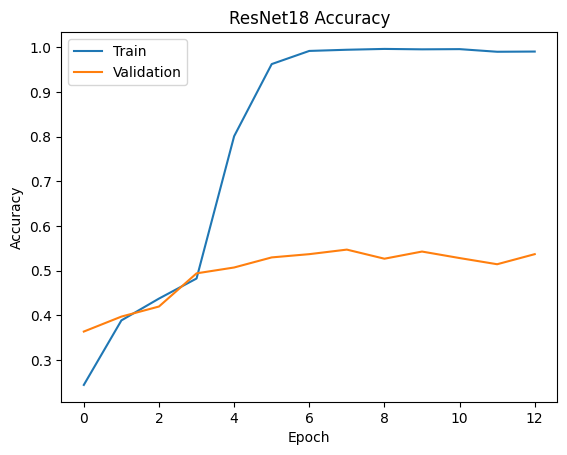

In [ ]:
train_acc = history_freeze["train_acc"] + history_unfreeze["train_acc"]
val_acc   = history_freeze["val_acc"]   + history_unfreeze["val_acc"]

plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(["Train", "Validation"])
plt.title("ResNet18 Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()


Matrice de confusion :

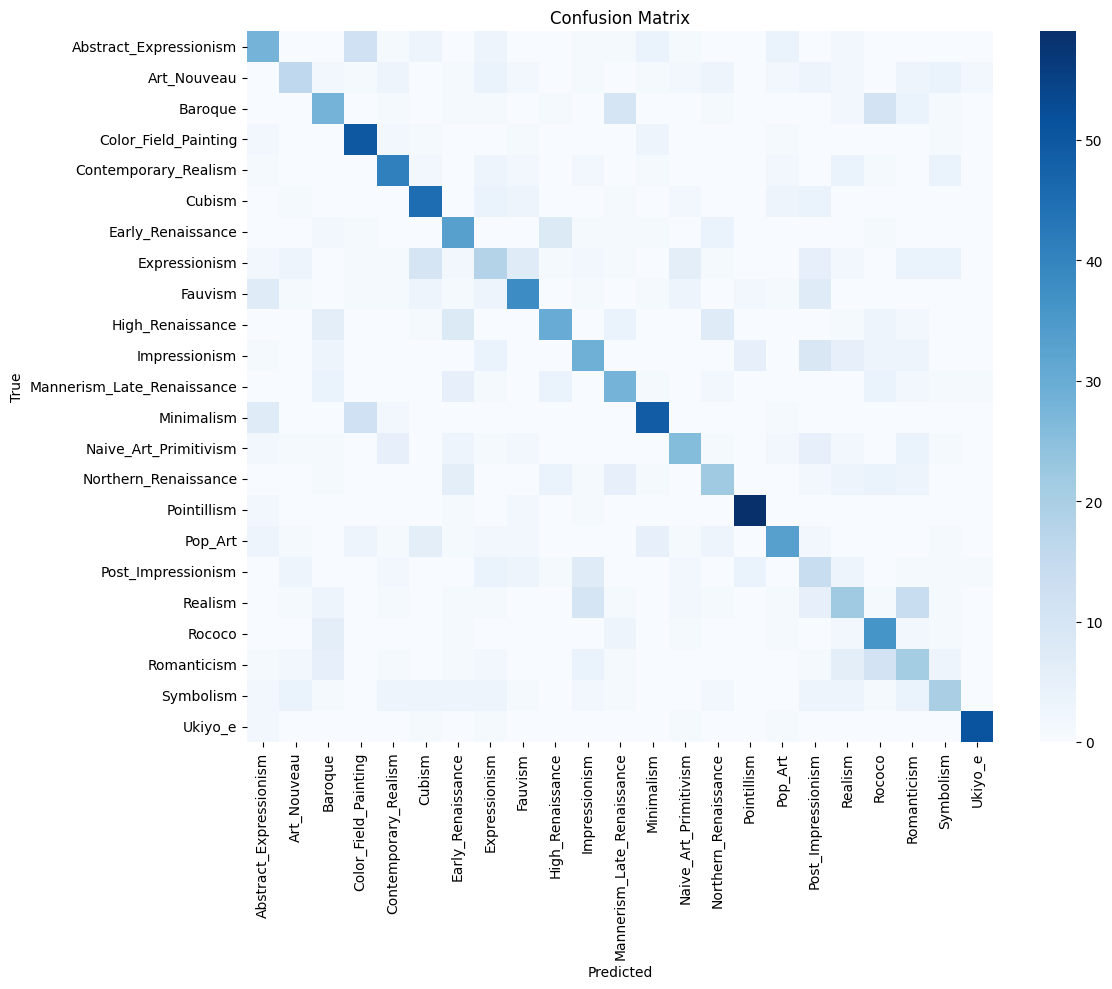

In [ ]:
#Confusion matrix :

class_names = sorted(df_train["style_name"].unique())

cm = compute_confusion_matrix(
    model,
    val_loader,
    device,
    class_names
)

plot_confusion_matrix(cm, class_names)


Accuracy par style :

In [ ]:
class_names = sorted(df_train["style"].unique())

acc_per_style = accuracy_per_class(
    model,
    val_loader,
    device,
    class_names
)

results = list(zip(class_names, acc_per_style))
results = sorted(results, key=lambda x: x[1], reverse=True)

for style, acc in results:
    print(f"{style}: {acc:.3f}")


18: 0.908
26: 0.895
5: 0.820
7: 0.714
14: 0.690
22: 0.679
6: 0.651
8: 0.635
10: 0.543
13: 0.528
19: 0.516
11: 0.484
12: 0.468
0: 0.467
15: 0.464
4: 0.459
17: 0.423
24: 0.357
23: 0.356
21: 0.338
3: 0.308
20: 0.304
9: 0.257


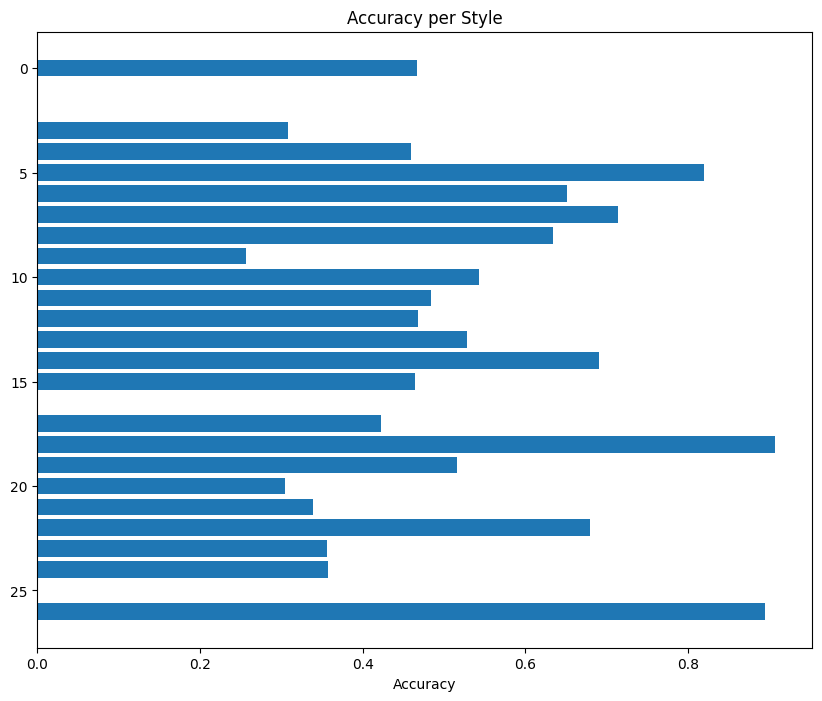

In [ ]:
visualize_accuracy_per_style(results)

#### 1.4.2 Evaluation test

In [ ]:
best_model_weights = model.state_dict()

test_acc, test_cm, report = evaluate_model(model, test_loader, device)

print(f"Test Accuracy: {test_acc:.3f}")
print("Classification Report:")
print(report)

: 

### 1.5 Second modèle ResNet18

Surapprentissage très fort; modèle utilisé : Freeze 3 epochs, Unfreeze tout 10 epochs à 1e-4
On change de stratégie :
Early stopping, dropout, unfreeze unqiuement layer 4, label smoothing.

In [ ]:
num_classes = df_train["style_encoded"].nunique()
model_02 = get_resnet18(num_classes=num_classes, device=device, drop=True)

# ajout de label smoothing pour la cross entropy loss
# label smoothing permet de rendre le modèle moins confiant dans ses prédictions,
# ce qui peut aider à améliorer la généralisation et réduire le surapprentissage
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = torch.optim.Adam(
    model_02.fc.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 145MB/s]


In [ ]:
class EarlyStopping:
    def __init__(self, patience=3):
        self.patience = patience
        self.best_loss = float("inf")
        self.counter = 0
        self.stop = False

    def step(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True

In [ ]:
print(model_02.fc)
print(len(df_train['style_encoded'].unique()))
print(sorted(df_train['style_encoded'].unique()))

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=512, out_features=23, bias=True)
)
23
[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22)]


In [ ]:
# from src.utils import EarlyStopping

early_stopping = EarlyStopping(patience=3)

NUM_EPOCHS_FREEZE = 3
history_freeze_02 = train_model(
    model_02,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs=NUM_EPOCHS_FREEZE,
    early_stopping=early_stopping
)

# Débloquer layer4 et fc pour le fine-tuning
for param in model_02.parameters():
    param.requires_grad = False
for param in model_02.layer4.parameters():
    param.requires_grad = True
for param in model_02.fc.parameters():
    param.requires_grad = True

optimizer = optim.Adam(
    model_02.parameters(),
    lr=1e-4,
    weight_decay=1e-4)

NUM_EPOCHS_UNFREEZE = 7

history_unfreeze_02 = train_model(
    model_02,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs=NUM_EPOCHS_UNFREEZE,
    early_stopping=early_stopping
)




Epoch 1/3


  0%|          | 0/202 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:1118: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


KeyboardInterrupt: 

### 1.6 Evaluation du nouveau modèle

#### 1.6.1 Evaluation avec train + val

In [ ]:
train_acc = history_unfreeze_02["train_acc"] + history_freeze_02["train_acc"]
val_acc   = history_unfreeze_02["val_acc"] + history_freeze_02["val_acc"]

plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(["Train", "Validation"])
plt.title("ResNet18 Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
#Confusion matrix :

class_names = sorted(df_train["style"].unique())

cm = compute_confusion_matrix(
    model_02,
    val_loader,
    device,
    class_names
)

plot_confusion_matrix(cm, class_names)


In [ ]:
class_names = sorted(df_train["style"].unique())

acc_per_style = accuracy_per_class(
    model_02,
    val_loader,
    device,
    class_names
)

results = list(zip(class_names, acc_per_style))
results = sorted(results, key=lambda x: x[1], reverse=True)

for style, acc in results:
    print(f"{style}: {acc:.3f}")


In [ ]:
visualize_accuracy_per_style(results)

#### 1.6.2 Evaluation sur l'ensemble de test

In [ ]:
best_model_weights = model_02.state_dict()

test_acc, test_cm, report = evaluate_model(model_02, test_loader, device)

print(f"Test Accuracy: {test_acc:.3f}")
print("Classification Report:")
print(report)

In [ ]:
print("Test Confusion Matrix:")
plot_confusion_matrix(test_cm, class_names)

### 1.7 Troisième modèle ResNet18

on teste en freeze tout

In [ ]:
num_classes = df_train["style_encoded"].nunique()
model_03 = get_resnet18(num_classes=num_classes, device=device, drop=True)

# ajout de label smoothing pour la cross entropy loss
# label smoothing permet de rendre le modèle moins confiant dans ses prédictions,
# ce qui peut aider à améliorer la généralisation et réduire le surapprentissage
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = torch.optim.Adam(
    model_03.fc.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 145MB/s]


In [ ]:
# from src.utils import EarlyStopping

early_stopping = EarlyStopping(patience=3)

NUM_EPOCHS_FREEZE = 3
history_freeze_03 = train_model(
    model_03,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs=NUM_EPOCHS_FREEZE,
    early_stopping=early_stopping
)

optimizer = optim.Adam(
    model_03.parameters(),
    lr=1e-4,
    weight_decay=1e-4)

NUM_EPOCHS_UNFREEZE = 7

history_unfreeze_03 = train_model(
    model_03,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs=NUM_EPOCHS_UNFREEZE,
    early_stopping=early_stopping
)




Epoch 1/3


  0%|          | 0/202 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:1118: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


KeyboardInterrupt: 

### 1.8 Evaluation du Troisième modèle

#### 1.6.1 Evaluation avec train + val

In [ ]:
train_acc = history_unfreeze_03["train_acc"] + history_freeze_03["train_acc"]
val_acc   = history_unfreeze_03["val_acc"] + history_freeze_03["val_acc"]

plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(["Train", "Validation"])
plt.title("ResNet18 Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
#Confusion matrix :

class_names = sorted(df_train["style"].unique())

cm = compute_confusion_matrix(
    model_03,
    val_loader,
    device,
    class_names
)

plot_confusion_matrix(cm, class_names)


In [ ]:
class_names = sorted(df_train["style"].unique())

acc_per_style = accuracy_per_class(
    model_03,
    val_loader,
    device,
    class_names
)

results = list(zip(class_names, acc_per_style))
results = sorted(results, key=lambda x: x[1], reverse=True)

for style, acc in results:
    print(f"{style}: {acc:.3f}")


In [ ]:
visualize_accuracy_per_style(results)

#### 1.6.2 Evaluation sur l'ensemble de test

In [ ]:
best_model_weights = model_03.state_dict()

test_acc, test_cm, report = evaluate_model(model_03, test_loader, device)

print(f"Test Accuracy: {test_acc:.3f}")
print("Classification Report:")
print(report)

In [ ]:
print("Test Confusion Matrix:")
plot_confusion_matrix(test_cm, class_names)

### 1.9 Sauvegarde du modèle entrainé

In [ ]:
import os
SAVE_DIR = "/content/drive/MyDrive/models"
model_name_02 = "resnet18_baseline_02.pt"
os.makedirs("/content/drive/MyDrive/models", exist_ok=True)

save_path = os.path.join(SAVE_DIR, model_name_02)

torch.save({
    "model_state_dict": model_02.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "num_classes": num_classes,
    "learning_rate": 1e-3,
    "weight_decay": 1e-4,
    "batch_size": train_loader.batch_size,
    "architecture": "resnet18_baseline_frozen_dropout",
}, save_path)

model_name_03 = "resnet18_baseline_03.pt"

save_path = os.path.join(SAVE_DIR, model_name_03)

torch.save({
    "model_state_dict": model_03.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "num_classes": num_classes,
    "learning_rate": 1e-3,
    "weight_decay": 1e-4,
    "batch_size": train_loader.batch_size,
    "architecture": "resnet18_baseline_full_frozen_dropout",
}, save_path)

# Pour charger le modèle plus tard :
# checkpoint = torch.load(save_path, map_location=device)

# model = get_resnet18(
#     num_classes=checkpoint["num_classes"],
#     device=device
# )

# model.load_state_dict(checkpoint["model_state_dict"])

# model.eval()


## 2. Réseau entrainé sur image haute fréquences

### 2.1 Chargement du dataset haute fréquence

In [ ]:
from src.frequency_analysis import HighFrequencyTransform

In [ ]:
high_freq_transform = transforms.Compose([
    HighFrequencyTransform(kernel_size=9, sigma=2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [ ]:

train_dataset_high = ArtDataset(df_train,
    IMAGE_ROOT_TRAIN, transform=high_freq_transform)

val_dataset_high = ArtDataset(df_val,
    IMAGE_ROOT_VAL, transform=high_freq_transform)

test_dataset_high = ArtDataset(df_test,
    IMAGE_ROOT_TEST, transform=high_freq_transform)


In [ ]:
train_loader_high = DataLoader(
    train_dataset_high,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,     # ajuster selon ton CPU
    pin_memory=True
)

val_loader_high = DataLoader(
    val_dataset_high,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,     # ajuster selon ton CPU
    pin_memory=True
)

test_loader_high = DataLoader(
    test_dataset_high,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,     # ajuster selon ton CPU
    pin_memory=True
)

### 2.2 Entrainement du modèle

Surapprentissage très fort; modèle utilisé : Freeze 3 epochs, Unfreeze tout 10 epochs à 1e-4
On change de stratégie :
Early stopping, dropout, unfreeze unqiuement layer 4, label smoothing.

In [ ]:
num_classes = df_train["style_encoded"].nunique()
model_hf = get_resnet18(num_classes=num_classes, device=device, drop=True)

# ajout de label smoothing pour la cross entropy loss
# label smoothing permet de rendre le modèle moins confiant dans ses prédictions,
# ce qui peut aider à améliorer la généralisation et réduire le surapprentissage
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = torch.optim.Adam(
    model_hf.fc.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 145MB/s]


In [ ]:
# from src.utils import EarlyStopping

early_stopping = EarlyStopping(patience=3)

NUM_EPOCHS_FREEZE = 3
history_freeze_hf = train_model(
    model_hf,
    train_loader_high,
    val_loader_high,
    criterion,
    optimizer,
    device,
    num_epochs=NUM_EPOCHS_FREEZE,
    early_stopping=early_stopping
)





Epoch 1/3


  0%|          | 0/202 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:1118: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


KeyboardInterrupt: 

In [ ]:
# Débloquer layer4 et fc pour le fine-tuning
for param in model_hf.parameters():
    param.requires_grad = False
for param in model_hf.layer4.parameters():
    param.requires_grad = True
for param in model_hf.fc.parameters():
    param.requires_grad = True

optimizer = optim.Adam(
    model_hf.parameters(),
    lr=1e-4,
    weight_decay=1e-4)

NUM_EPOCHS_UNFREEZE = 7

history_unfreeze_hf = train_model(
    model_hf,
    train_loader_high,
    val_loader_high,
    criterion,
    optimizer,
    device,
    num_epochs=NUM_EPOCHS_UNFREEZE,
    early_stopping=early_stopping
)


### 2.3 Evaluation du nouveau modèle

#### 2.3.1 Evaluation avec train + val

In [ ]:
train_acc = history_unfreeze_hf["train_acc"] + history_freeze_hf["train_acc"]
val_acc   = history_unfreeze_hf["val_acc"] + history_freeze_hf["val_acc"]

plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(["Train", "Validation"])
plt.title("ResNet18 Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
#Confusion matrix :

class_names = sorted(df_train["style"].unique())

cm = compute_confusion_matrix(
    model_hf,
    val_loader_high,
    device,
    class_names
)

plot_confusion_matrix(cm, class_names)


In [ ]:
class_names = sorted(df_train["style"].unique())

acc_per_style = accuracy_per_class(
    model_hf,
    val_loader_high,
    device,
    class_names
)

results = list(zip(class_names, acc_per_style))
results = sorted(results, key=lambda x: x[1], reverse=True)

for style, acc in results:
    print(f"{style}: {acc:.3f}")


In [ ]:
visualize_accuracy_per_style(results)

#### 2.3.2 Evaluation sur l'ensemble de test

In [ ]:
best_model_weights = model_hf.state_dict()

test_acc, test_cm, report = evaluate_model(model_hf, test_loader_high, device)

print(f"Test Accuracy: {test_acc:.3f}")
print("Classification Report:")
print(report)

In [ ]:
print("Test Confusion Matrix:")
plot_confusion_matrix(test_cm, class_names)

## 3. Réseau entrainé sur image basse fréquences

### 3.1 Chargement du dataset basse fréquences

In [ ]:
from src.frequency_analysis import LowFrequencyTransform

In [ ]:
low_freq_transform = transforms.Compose([
    LowFrequencyTransform(kernel_size=9, sigma=2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [ ]:
train_dataset_low = ArtDataset(df_train,
    IMAGE_ROOT_TRAIN, transform=low_freq_transform)

val_dataset_low = ArtDataset(df_val,
    IMAGE_ROOT_VAL, transform=low_freq_transform)

test_dataset_low = ArtDataset(df_test,
    IMAGE_ROOT_TEST, transform=low_freq_transform)

In [ ]:
train_loader_low = DataLoader(
    train_dataset_low,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,     # ajuster selon ton CPU
    pin_memory=True
)

val_loader_low = DataLoader(
    val_dataset_low,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,     # ajuster selon ton CPU
    pin_memory=True
)

test_loader_low = DataLoader(
    test_dataset_low,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,     # ajuster selon ton CPU
    pin_memory=True
)

### 3.2 Entrainement du modèle

Surapprentissage très fort; modèle utilisé : Freeze 3 epochs, Unfreeze tout 10 epochs à 1e-4
On change de stratégie :
Early stopping, dropout, unfreeze unqiuement layer 4, label smoothing.

In [ ]:
num_classes = df_train["style_encoded"].nunique()
model_lf = get_resnet18(num_classes=num_classes, device=device, drop=True)

# ajout de label smoothing pour la cross entropy loss
# label smoothing permet de rendre le modèle moins confiant dans ses prédictions,
# ce qui peut aider à améliorer la généralisation et réduire le surapprentissage
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = torch.optim.Adam(
    model_lf.fc.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 145MB/s]


In [ ]:
# from src.utils import EarlyStopping

early_stopping = EarlyStopping(patience=3)

NUM_EPOCHS_FREEZE = 3
history_freeze_lf = train_model(
    model_lf,
    train_loader_low,
    val_loader_low,
    criterion,
    optimizer,
    device,
    num_epochs=NUM_EPOCHS_FREEZE,
    early_stopping=early_stopping
)





Epoch 1/3


  0%|          | 0/202 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:1118: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


KeyboardInterrupt: 

In [ ]:
# Débloquer layer4 et fc pour le fine-tuning
for param in model_lf.parameters():
    param.requires_grad = False
for param in model_lf.layer4.parameters():
    param.requires_grad = True
for param in model_lf.fc.parameters():
    param.requires_grad = True

optimizer = optim.Adam(
    model_lf.parameters(),
    lr=1e-4,
    weight_decay=1e-4)

NUM_EPOCHS_UNFREEZE = 7

history_unfreeze_lf = train_model(
    model_lf,
    train_loader_low,
    val_loader_low,
    criterion,
    optimizer,
    device,
    num_epochs=NUM_EPOCHS_UNFREEZE,
    early_stopping=early_stopping
)


### 3.3 Evaluation du nouveau modèle

#### 3.3.1 Evaluation avec train + val

In [ ]:
train_acc = history_unfreeze_lf["train_acc"] + history_freeze_lf["train_acc"]
val_acc   = history_unfreeze_lf["val_acc"] + history_freeze_lf["val_acc"]

plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(["Train", "Validation"])
plt.title("ResNet18 Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
#Confusion matrix :

class_names = sorted(df_train["style"].unique())

cm = compute_confusion_matrix(
    model_lf,
    val_loader_low,
    device,
    class_names
)

plot_confusion_matrix(cm, class_names)


In [ ]:
class_names = sorted(df_train["style"].unique())

acc_per_style = accuracy_per_class(
    model_lf,
    val_loader_low,
    device,
    class_names
)

results = list(zip(class_names, acc_per_style))
results = sorted(results, key=lambda x: x[1], reverse=True)

for style, acc in results:
    print(f"{style}: {acc:.3f}")


In [ ]:
visualize_accuracy_per_style(results)

#### 3.3.2 Evaluation sur l'ensemble de test

In [ ]:
best_model_weights = model_lf.state_dict()

test_acc, test_cm, report = evaluate_model(model_lf, test_loader_low, device)

print(f"Test Accuracy: {test_acc:.3f}")
print("Classification Report:")
print(report)

In [ ]:
print("Test Confusion Matrix:")
plot_confusion_matrix(test_cm, class_names)